# Downloading data

In [1]:
import torch

# Other files
import utils
from models.autowarp import AutoWarp
from models.mean_variance_optimisation import MeanVarianceOptimisation
from models.autoencoders import LinearAutoencoder, ConvAutoencoder, ConvLinearAutoEncoder, train_autoencoder, get_distance_matrix

# General imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

# Optimisation
from pypfopt.expected_returns import mean_historical_return

import yfinance as yf

# Set seed for reproducibility
torch.manual_seed(0)
np.random.seed(0);

In [2]:
# 2 years training (split into 1 year train and 1 year valid), 18 months test
start_date = '2017-03-01'
valid_date = '2018-03-01'
train_date = '2019-03-01'
end_date   = '2020-09-01'

prices_train, _, _, prices_test = utils.split_prices(start_date=start_date, valid_date=valid_date, train_date=train_date, end_date=end_date, train_valid_split=2/3)
data_train, _ = utils.split_orbis_data(start_date=start_date, valid_date=valid_date, train_date=train_date, returns=True, momentum=True, train_valid_split=2/3)

import json
# Open json file
with open(f'params/sp500_{start_date}.json') as f:
    params = json.load(f)

num_epochs=20

In [3]:
# S&P 500
sp500 = yf.download("^GSPC", start=train_date, end=end_date, period="1d")['Adj Close']
sp500 = sp500.div(sp500.iloc[0]).mul(100)

[*********************100%***********************]  1 of 1 completed


In [4]:
# # Dict for matrices
# params = {'Linear': {}, 'CNN': {}, 'Linear + CNN': {}}
#
# params['Linear']['autoencoder'] = {'latent_size': 41, 'hidden_size': 201, 'batch_size': 21}
# params['Linear']['dist_matrix'] = {'latent_size': 41, 'p': 0.5, 'max_iterations': 50, 'batch_size': 25, 'lr': 0.01}
# params['Linear']['risk_matrix'] = {'C': -0.45062589027080474}
#
# params['CNN']['autoencoder'] = {'latent_size': 38, 'hidden_size': 292, 'batch_size': 27}
# params['CNN']['dist_matrix'] = {'latent_size': 38, 'p': 0.5, 'max_iterations': 50, 'batch_size': 25, 'lr': 0.01}
# params['CNN']['risk_matrix'] = {'C': -0.41643980400603453}
#
# params['Linear + CNN']['autoencoder'] = {'latent_size': 37, 'hidden_size': 265, 'hidden_size2': 211, 'batch_size': 23}
# params['Linear + CNN']['dist_matrix'] = {'latent_size': 37, 'p': 0.5, 'max_iterations': 50, 'batch_size': 25, 'lr': 0.01}
# params['Linear + CNN']['risk_matrix'] = {'C': -0.4728019352074843}
#
# num_epochs=20

In [27]:
for m in params:
    print(m)

Linear
CNN
Linear + CNN


# Calculating distance matrix

In [5]:
models = {}
models['Linear'] = train_autoencoder(LinearAutoencoder, input_size=data_train.shape[1], num_epochs=num_epochs, data=data_train, verbose=True, **params['Linear']['autoencoder'])
models['CNN'] = train_autoencoder(ConvAutoencoder, input_size=data_train.shape[1], num_epochs=num_epochs, data=data_train, verbose=True, **params['CNN']['autoencoder'])
models['Linear + CNN'] =train_autoencoder(ConvLinearAutoEncoder, input_size=data_train.shape[1], num_epochs=num_epochs, data=data_train, verbose=True, **params['Linear + CNN']['autoencoder'])

LinearAutoencoder
Epoch [1/20], Loss: 0.0781
Epoch [2/20], Loss: 0.0194
Epoch [3/20], Loss: 0.0159
Epoch [4/20], Loss: 0.0146
Epoch [5/20], Loss: 0.0140
Epoch [6/20], Loss: 0.0134
Epoch [7/20], Loss: 0.0126
Epoch [8/20], Loss: 0.0113
Epoch [9/20], Loss: 0.0101
Epoch [10/20], Loss: 0.0092
Epoch [11/20], Loss: 0.0085
Epoch [12/20], Loss: 0.0081
Epoch [13/20], Loss: 0.0078
Epoch [14/20], Loss: 0.0076
Epoch [15/20], Loss: 0.0074
Epoch [16/20], Loss: 0.0072
Epoch [17/20], Loss: 0.0071
Epoch [18/20], Loss: 0.0069
Epoch [19/20], Loss: 0.0068
Epoch [20/20], Loss: 0.0067
ConvAutoencoder
Epoch [1/20], Loss: 0.1299
Epoch [2/20], Loss: 0.0728
Epoch [3/20], Loss: 0.0642
Epoch [4/20], Loss: 0.0503
Epoch [5/20], Loss: 0.0373
Epoch [6/20], Loss: 0.0281
Epoch [7/20], Loss: 0.0230
Epoch [8/20], Loss: 0.0185
Epoch [9/20], Loss: 0.0160
Epoch [10/20], Loss: 0.0138
Epoch [11/20], Loss: 0.0129
Epoch [12/20], Loss: 0.0123
Epoch [13/20], Loss: 0.0117
Epoch [14/20], Loss: 0.0115
Epoch [15/20], Loss: 0.0113
Epoc

In [14]:
%%time
dist_matrices = {}
for model in ['Linear', 'Linear + CNN', 'CNN']:
    print(model)
    learner = AutoWarp(models[model], data_train, **params[model]['dist_matrix'])
    learner.learn_metric()
    dist_matrices[model] = learner.create_distance_matrix()

Linear
Linear + CNN
CNN
CPU times: total: 8min 37s
Wall time: 1min 54s


# Mean variance optimisation

In [15]:
# Empty dict for weights
weights = {}

#for model in ["Linear", "Linear + CNN"]:
for model in ["Linear", "CNN", "Linear + CNN"]:

    # Setup
    e_returns = mean_historical_return(prices_train)
    optimiser = MeanVarianceOptimisation(expected_returns = e_returns, prices = prices_train, solver='OSQP', weight_bounds = (0,1))

    # Get weights
    risk_matrix = optimiser.make_risk_matrix(dist_matrices[model], **params[model]['risk_matrix'])
    weights[model], train_sr = optimiser.max_sharpe_ratio(risk_matrix=risk_matrix, l2_reg=0)

    # Print out summary
    print(model, train_sr)

#for model in ["Covariance", "Covariance Shrinkage", "Exponentially Weighted Covariance"]:
for model in ["Covariance", "Covariance Shrinkage"]:

    # Setup
    e_returns = mean_historical_return(prices_train)
    optimiser = MeanVarianceOptimisation(expected_returns = e_returns, prices = prices_train, solver='OSQP', weight_bounds = (0,1))

    # Get weights
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        risk_matrix = optimiser.benchmark_matrix(model)
        weights[model], train_sr = optimiser.max_sharpe_ratio(risk_matrix=risk_matrix, l2_reg=0)

    # Print out summary
    print(model, train_sr)

# Equal weights
weights['Equal'] = weights['Linear'].copy()
weights['Equal']['weights'] = 1/weights['Linear']['weights'].shape[0]
print("Equal", utils.calculate_sharpe_ratio(weights=weights['Equal'], prices=prices_train))

Linear 2.0515016054401736
CNN 2.0385413735070497
Linear + CNN 1.5866675490361744
Covariance 2.470835751621722
Covariance Shrinkage 2.4702165386245456
Equal 0.9015352499409959


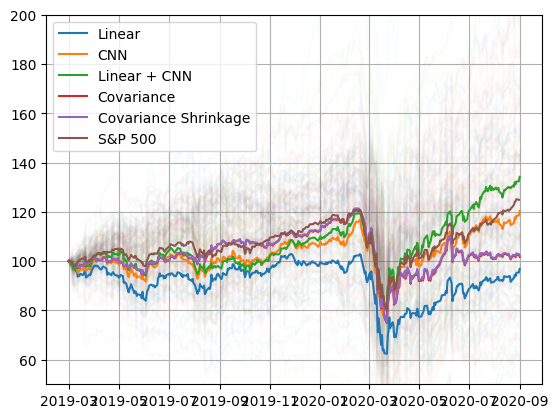

In [16]:
# Plots
plt.plot(prices_test, alpha=0.025)
#for model in ["Linear", "Linear + CNN", "Covariance", "Covariance Shrinkage", "Equal"]:
for model in ["Linear", "CNN", "Linear + CNN", "Covariance", "Covariance Shrinkage"]:
    plt.plot(prices_test @ weights[model], label=model)
plt.plot(sp500, label="S&P 500")
plt.ylim(50, 200)
plt.grid()
plt.legend();

In [17]:
# Sharpe ratios
rf = 0.02

# for model in ["Linear", "CNN", "Covariance", "Covariance Shrinkage", "Equal"]:
for model in ["Linear", "CNN", "Linear + CNN", "Covariance", "Covariance Shrinkage", "Equal"]:
    print(model, "sharpe",  utils.calculate_sharpe_ratio(prices = prices_test, weights = weights[model]))
    #print(model, "std",utils.calculate_sd(prices = prices_test, weights = weights[model]))

sp500_returns =((sp500/sp500.shift(1))-1).dropna()
with warnings.catch_warnings(record=True):
    warnings.simplefilter("always")
    effr = pd.read_excel('data/EFFR.xlsx', sheet_name='Results', index_col=0, usecols='A:C', engine="openpyxl")
effr = effr.drop(columns='Rate Type', axis=1)
effr.index = pd.to_datetime(effr.index)
effr['Rate (%)'] = effr['Rate (%)'] / (100*252)

# Calculate excess returns
sp500_returns = pd.merge(sp500_returns, effr, how='left', left_index=True, right_index=True)
sp500_returns['Rate (%)'] = sp500_returns['Rate (%)'].fillna(method='ffill')
assert sp500_returns.isnull().sum().sum() == 0
sp500_returns['excess_returns'] = sp500_returns['Adj Close'] - sp500_returns['Rate (%)']

# Calculate Sharpe Ratio
avg_return = sp500_returns['excess_returns'].mean() * 252
std = sp500_returns['excess_returns'].std() * np.sqrt(252)
sharpe = avg_return / std
print("S&P 500", sharpe)

Linear sharpe 0.07645682337239182
CNN sharpe 0.49082442157417794
Linear + CNN sharpe 0.7340420558614537
Covariance sharpe 0.1436743329778641
Covariance Shrinkage sharpe 0.15277549466547194
Equal sharpe 0.5454878410346725
S&P 500 0.6161959475496861


In [18]:
for model in ["Linear", "CNN", "Linear + CNN", "Covariance", "Covariance Shrinkage"]:
    print(model, "number of stocks included:", np.count_nonzero(weights[model]))

Linear number of stocks included: 7
CNN number of stocks included: 8
Linear + CNN number of stocks included: 12
Covariance number of stocks included: 16
Covariance Shrinkage number of stocks included: 16


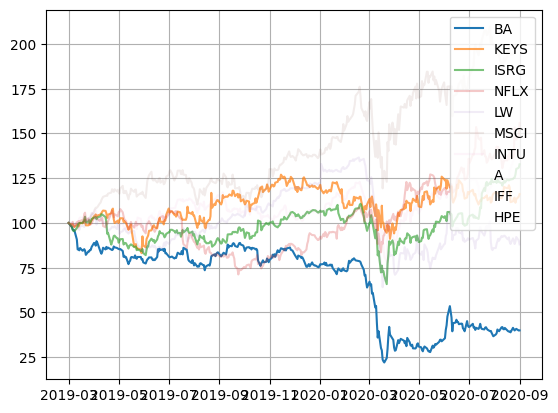

In [19]:
# Plot performance of Linear stocks
for i in weights['Linear'].sort_values(by='weights', ascending=False).head(10).index:
    plt.plot(prices_test[i], label=i, alpha=min(weights['Linear'].loc[i, 'weights']*3, 1))
plt.legend()
plt.grid();

# HRP

In [20]:
from models.hrp import HRPOpt
rets = (prices_train/prices_train.shift(1)-1).dropna()
hrp = HRPOpt(rets)
hrp.optimize(dist_matrix=dist_matrices['Linear'])
weights_hrp = hrp.clean_weights()

C:\Users\roryc\Documents\_Git\portfolio_metric_learning\models\hrp.py:172: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  self.clusters = sch.linkage(dist, linkage_method)


In [21]:
weights_hrp = pd.DataFrame.from_dict(weights_hrp, orient='index', columns=['weights'])

In [57]:
# Empty dict for weights
weights_hrp = {}

rets = (prices_train/prices_train.shift(1)-1).dropna()
hrp = HRPOpt(rets)

# for model in ["Linear", "Linear + CNN"]:
for model in ["Linear", "CNN", "Linear + CNN"]:

    hrp.optimize(dist_matrix=-dist_matrices[model])
    weights_hrp[model] = pd.DataFrame.from_dict(hrp.clean_weights(), orient='index', columns=['weights'])

hrp.optimize()
weights_hrp['Benchmark'] = pd.DataFrame.from_dict(hrp.clean_weights(), orient='index', columns=['weights'])

# Equal weights
weights_hrp['Equal'] = weights_hrp['Linear'].copy()
weights_hrp['Equal']['weights'] = 1/weights_hrp['Linear']['weights'].shape[0]

ValueError: The condensed distance matrix must contain only finite values.

In [23]:
# Sharpe ratios
rf = 0.02

for model in ["Linear", "CNN", "Linear + CNN", "Benchmark", "Equal"]:
# for model in ["Linear", "Linear + CNN", "Benchmark", "Equal"]:
    print(model, utils.calculate_sharpe_ratio(prices = prices_test, weights = weights_hrp[model]))

Linear 0.48931999433153356
CNN 0.4995232459267143
Linear + CNN 0.48792816954534923
Benchmark 0.5100842202279492
Equal 0.5454878410346725


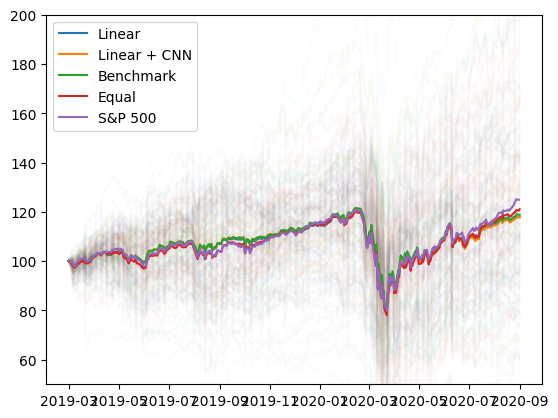

In [24]:
# Plots
plt.plot(prices_test, alpha=0.025)
# for model in ["Linear", "CNN", "Linear + CNN", "Benchmark", "Equal"]:
for model in ["Linear", "Linear + CNN", "Benchmark", "Equal"]:
    plt.plot(prices_test @ weights_hrp[model], label=model)
plt.plot(sp500, label="S&P 500")
plt.ylim(50, 200)
plt.legend();

In [25]:
for model in ["Linear", "CNN", "Linear + CNN", "Benchmark"]:
    print(model, "number of stocks included:", np.count_nonzero(weights_hrp[model]))

Linear number of stocks included: 200
CNN number of stocks included: 200
Linear + CNN number of stocks included: 200
Benchmark number of stocks included: 200


In [59]:
pd.DataFrame.to_dict(weights['Linear'])

{'weights': {'A': 0.0,
  'AAP': 0.0,
  'AAPL': 0.0,
  'ABBV': 0.0,
  'ABC': 0.0,
  'ABT': 0.0,
  'ADBE': 0.0,
  'ADI': 0.0,
  'ADM': 0.0,
  'ADP': 0.0,
  'ADSK': 0.0,
  'AEE': 0.0,
  'AEP': 0.0,
  'AES': 0.0,
  'AJG': 0.0,
  'AKAM': 0.0,
  'ALB': 0.0,
  'ALK': 0.0,
  'AMAT': 0.0,
  'AMD': 0.0,
  'AME': 0.0,
  'AMGN': 0.0,
  'AMT': 0.0,
  'AMZN': 0.0,
  'ANET': 0.0,
  'ANSS': 0.0,
  'AOS': 0.0,
  'APH': 0.0,
  'ATO': 0.0,
  'ATVI': 0.0,
  'AVY': 0.0,
  'AWK': 0.0,
  'AZO': 0.0,
  'BA': 0.37528,
  'BAX': 0.0,
  'BBY': 0.0,
  'BDX': 0.0,
  'BIIB': 0.0,
  'BKNG': 0.0,
  'BMY': 0.0,
  'BR': 0.0,
  'BWA': 0.0,
  'BXP': 0.0,
  'CAG': 0.0,
  'CAH': 0.0,
  'CAT': 0.0,
  'CBOE': 0.0,
  'CBRE': 0.0,
  'CE': 0.0,
  'CF': 0.0,
  'CHRW': 0.0,
  'CL': 0.0,
  'CLX': 0.0,
  'CMCSA': 0.0,
  'CMG': 0.0,
  'CMI': 0.0,
  'CMS': 0.0,
  'COP': 0.0,
  'COST': 0.0,
  'CPB': 0.0,
  'CPRT': 0.0,
  'CRM': 0.0,
  'CSCO': 0.0,
  'CTAS': 0.0,
  'CTSH': 0.0,
  'CVS': 0.0,
  'CVX': 0.0,
  'D': 0.0,
  'DE': 0.0,
  'DG'